## Race Forecasting
This notebook uses precomputed computed features such as the best two z scores from a dogs past 5 races combined with a logistic regression to compute market odds. This is compared to market odds, and bets are made if there is significant enough value in market odds compared to our calculated probability. Methods to filter out tracks, such as a training sample to select profitable tracks, were tested however it was determined betting on all tracks provides better returns. A test sample is conducted on 2025 races demonstrating significant return per bet of 36% and a 41% win rate.

Forward testing is still undergoing with a AWS Lambda, S3 and slack system.


In [10]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [11]:
data = pd.read_csv('../dog_data5.csv')
for col in data.columns:
    if 'Unnamed' in col:
        data.drop(col, axis=1, inplace=True)
data = data[~data['Track'].isin(['richmond straight', 'healesville', 'capalaba', 'murray bridge'])]
data = data[(data['Distance']>0) & (data['Distance']<521) ]
data = data.drop_duplicates(subset=['DogName','RunTime','RaceId'],keep='first')
data = data.rename(columns={'of_time_11_relative':'best_two_of_five_races_relative_zs'})

data['Date'] = data['Date'].str.split(' ').str[0]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.sort_values(by='Date')

data.head(5)

,Track,DogName,RunTime,Split,Place,Date,RaceId,Distance,Box,Weight,...,Win,best_two_of_five_races_relative_zs,of_time_12_relative,0,-10,-5,-1,5,10,-2
17561,nowra,lightning rocket,20.840,8.5300,2.0,2022-11-07,841163995.0,365.0,2.0,29.9,...,0,-0.716983,-0.477037,7.5,7.5,NaN,7.0,8.5,8.0,7.5
17533,nowra,freeway split,20.690,8.5000,1.0,2022-11-07,841163994.0,365.0,7.0,34.2,...,1,0.126664,-0.963058,11.0,6.5,NaN,6.5,8.5,7.5,6.0
17534,horsham,galaxy oasis,28.028,6.7645,5.0,2022-11-07,841190546.0,485.0,4.0,31.2,...,0,0.078602,0.255362,15.0,15.0,NaN,14.0,18.0,15.0,15.0
17535,horsham,gladiator hulk,23.383,10.5975,4.0,2022-11-07,841190542.0,410.0,2.0,36.9,...,0,-0.458278,-0.047091,41.0,23.0,NaN,21.0,26.0,17.0,19.0
17536,albion park,hammer drill,31.050,5.8900,4.0,2022-11-07,841164016.0,520.0,8.0,26.9,...,0,-0.213570,-0.071083,61.0,91.0,NaN,91.0,26.0,26.0,81.0


In [12]:
def all_tracks(data):
    tracks_dists = data.groupby(['Track', 'Distance'])
    top_tracks = {}
    for trk, d in tracks_dists.groups.keys():
        if trk not in top_tracks:
            top_tracks[trk] = [int(d)]
        else:
            
            top_tracks[trk].append(int(d))

    return top_tracks




Total bets: 131
Total profit: 47.59999999999999
Win rate: 41.22%
ROI: 0.36
Time period: 2025-01-04 00:00:00 - 2025-06-25 00:00:00


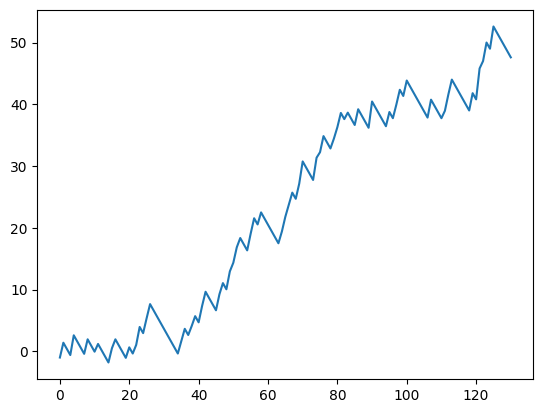

In [13]:
###2025 simulation
initial_training_frac = 0.33
cv_folds = 3

bets = []
wins = 0
losses = 0
money = 0



train = data[data['Date'].dt.year < 2025]  # Use data before 2025 for training
test = data[data['Date'].dt.year >= 2025]  # Use data from 2025 onwards for testing

# top_tracks = top_tracks_by_past_sim(train, 30)
top_tracks = all_tracks(train)


scratchings = pd.read_csv('scratchings.csv')
scratchings = scratchings[scratchings['isLateScratching'] == False]
scratched_ids = scratchings['raceId'].unique().tolist()

for track in top_tracks.keys():
    for distance in top_tracks[track]:

        

        train_subset = train[(train['Track'] == track) & (train['Distance'] == distance)]
        test_subset = test[(test['Track'] == track) & (test['Distance'] == distance)]

        if train_subset.shape[0] < 100 or test_subset.shape[0] < 10 or len(train_subset['Win'].unique()) < 2:
                # print(f'Skipping track {track} distance {distance} due to insufficient data. Train size: {train_subset.shape[0]}, Test size: {test_subset.shape[0]}, Unique Wins: {len(train_subset["Win"].unique())}')
                continue

        model = LogisticRegression()
        model.fit(train_subset[['best_two_of_five_races_relative_zs']], train_subset['Win'])

        train_race_ids = train_subset['RaceId'].unique().tolist()
        test_race_ids = test_subset['RaceId'].unique().tolist()

        race_ids = list(set(test_race_ids) - set(train_race_ids))


        race_ids = list(set(race_ids).intersection(set(scratched_ids))) ## only use races that are scratched,but not late scratched
        # race_ids = list(set(race_ids)- set(scratched_ids)) ## bets on non-scratched races

        if len(race_ids) == 0:
            continue

        for rid  in race_ids:
            race = test[test['RaceId'] == rid].copy()
            
            if len(race) == 0:
                continue
            
            predictions = model.predict_proba(race[['best_two_of_five_races_relative_zs']])
            race['prob_win'] = predictions[:,1]
            race['prob_win'] = race['prob_win']/sum(race['prob_win'])
            race['odds'] = 1 / race['prob_win']

            ### our favourite
            our_favourite = race['odds'].idxmin()
            favourite_row = race.loc[our_favourite]
            our_favourite_odds = favourite_row['odds']

            price_column = '0'

            ### bookie favourite at different times
            favourite_bstart = race[price_column].idxmin()
            match_favs_start = favourite_bstart == our_favourite

            if (match_favs_start) and race.shape[0]>4:

                if favourite_row[price_column] - favourite_row['odds'] > 0.25:
                # if  favourite_row['prob_win'] - 1/favourite_row[price_column] > 0.1:
                # if(1 == 1):

                    if favourite_row['Win'] == 1:
                        wins += 1
                        money += (favourite_row[price_column] - 1) 
                        bets.append({
                            'RaceId': rid,
                            'date': favourite_row['Date'],
                            'Distance': favourite_row['Distance'],
                            'Track': favourite_row['Track'],
                            'our_favourite_odds': our_favourite_odds,
                            'bookie_odds': favourite_row[price_column],
                            'payout': favourite_row[price_column] - 1,
                            'win': 1
                        })
                        
                    else:
                        losses += 1
                        money -= 1
                        bets.append({
                            'RaceId': rid,
                            'date': favourite_row['Date'],
                            'Distance': favourite_row['Distance'],
                            'Track': favourite_row['Track'],
                            'our_favourite_odds': our_favourite_odds,
                            'bookie_odds': favourite_row[price_column],
                            'payout': -1,
                            'win': 0
                        })
        
if len(bets) != 0:
    bets_df = pd.DataFrame(bets)
    bets_df = bets_df.sort_values(by='date')
    bets_df['money'] = bets_df['payout'].cumsum()
    bets_df.reset_index(inplace=True)

    print(f'Total bets: {bets_df.shape[0]}')
    print(f'Total profit: {bets_df["money"].iloc[-1]}')
    print(f'Win rate: {bets_df[bets_df["win"] == 1].shape[0] / bets_df.shape[0] * 100:.2f}%')
    print(f'ROI: {bets_df["money"].iloc[-1] / bets_df.shape[0]:.2f}')
    print(f'Time period: {bets_df["date"].min()} - {bets_df["date"].max()}')

    plt.plot(bets_df['money'])
    plt.show()
else:
    print("No bets were placed during the simulation period.")